In [3]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols, glm
from urllib.parse import urlparse
import re
from urllib.parse import urlparse
import requests
from urllib.parse import urlparse
from bs4 import BeautifulSoup

In [4]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [5]:
workspace_path = '/gdrive/My Drive/Colab Notebooks/capstone/'

In [6]:
ph_df = pd.read_csv(os.path.join(workspace_path, 'phishing.csv'), sep=',', header=0, engine='python')
norm = pd.read_csv(os.path.join(workspace_path, 'normal.csv'), sep=',', header=0, engine='python', encoding='latin1')
norm1 = pd.read_csv(os.path.join(workspace_path, 'normal1.csv'), sep=',', header=0, engine='python')
norm2 = pd.read_csv(os.path.join(workspace_path, 'normal2.csv'), sep=',', header=0, engine='python', encoding='latin1')

In [7]:
norm1['url'] = 'https://' + norm1['url']

In [8]:
norm.head()

,url
0,https://www.mavia.com/
1,https://credinetweb.bcp.com.bo/#/login
2,https://login.live.com.office.ausunitypreprod....
3,https://login.live.com.office.ausunitypreprod....
4,http://login.live.com.office.urgo-prod1.labora...


In [9]:
norm1.head()

,url
0,https://google.com
1,https://youtube.com
2,https://facebook.com
3,https://baidu.com
4,https://wikipedia.org


In [10]:
norm2.head()

,url
0,http://socialdisasterscommission.go.kr/
1,http://www.bai.go.kr/mobile/index.do
2,http://www.bai.go.kr
3,http://www.bai.go.kr/child/index.do
4,http://www.pasa.go.kr


In [11]:
ph_df.head()

,url
0,https://kirpalthakur.com/ionos/
1,http://tinyurl.com/77drs68j
2,http://tinyurl.com/5n99993x
3,https://docs.google.com/presentation/d/e/2PACX...
4,https://docs.google.com/presentation/d/e/2PACX...


In [12]:
norm_df = pd.concat([norm1[:2000], norm2[:2000], norm[:51000]], ignore_index=True)

In [13]:
ph_df.shape

(55211, 1)

In [14]:
norm_df.shape

(55000, 1)

In [15]:
print(norm1.shape)
print(norm2.shape)

(1000000, 1)
(22341, 1)


In [16]:
# 피처 추출 함수
def extract_features(url):
    parsed_url = urlparse(url)
    domain = parsed_url.netloc  # 도메인 부분 추출

    features = {
        'contains_at': int('@' in url),
        'contains_dash': int('-' in url),
        'url_length': len(domain),  # 도메인 길이 계산
        'is_https': int(url.startswith('https://')),
        'digit_count': sum(c.isdigit() for c in domain),
        'double_slash': int(url.count('//') > 1),
        'is_shortened': int(any(shortener in url for shortener in ['bit.ly', 'goo.gl', 'tinyurl.com'])),
        'subdomain_count': domain.count('.') - 1 if domain.startswith('www.') else domain.count('.')
    }
    return features



def extract_features2(url):
    features = {}
    parsed_url = urlparse(url)

    # 1. 웹사이트 생성 날짜
    try:
        domain_info = whois.whois(parsed_url.netloc)
        features['creation_date'] = domain_info.creation_date
    except Exception:
        features['creation_date'] = None

    # 2. URL 내용이 소스코드 내에 포함
    try:
        response = requests.get(url, timeout=5)
        features['url_in_source'] = url in response.text
    except Exception:
        features['url_in_source'] = False

    # 3. 비표준 포트 사용
    port = parsed_url.port
    features['non_standard_port'] = port not in [None, 80, 443]

    # 4. HTML 소스코드 길이
    try:
        features['source_code_length'] = len(response.text)
    except Exception:
        features['source_code_length'] = None

    return features


# 데이터프레임에 피처 추출 적용 함수
def extract_features_from_dataframe(df):
    features_list = []
    for url in df['url']:
        features = extract_features(url)
        # features2 = extract_features2(url)
        # features.update(features2)
        features_list.append(features)

    features_df = pd.DataFrame(features_list)
    return features_df

In [17]:
# 피처 추출
ph_features_df = extract_features_from_dataframe(ph_df)
norm_features_df = extract_features_from_dataframe(norm_df)

In [18]:

# 피싱 및 정상 데이터셋에 레이블 추가
ph_features_df['label'] = 1  # 피싱 URL
norm_features_df['label'] = 0  # 정상 URL

In [19]:
# 데이터셋 병합
ph_val = ph_features_df.sample(n=5000, random_state=42)
ph_train = ph_features_df.drop(ph_val.index)

norm_val = norm_features_df.sample(n=5000, random_state=42)
norm_train = norm_features_df.drop(norm_val.index)

valset = pd.concat([ph_val, norm_val])
df = pd.concat([ph_train, norm_train], ignore_index=True)

In [20]:
df.head()

,contains_at,contains_dash,url_length,is_https,digit_count,double_slash,is_shortened,subdomain_count,label
0,0,0,16,1,0,0,0,1,1
1,0,0,11,0,0,0,1,1,1
2,0,0,11,0,0,0,1,1,1
3,0,1,15,1,0,0,0,2,1
4,0,0,16,1,0,0,0,2,1


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100211 entries, 0 to 100210
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype
---  ------           --------------   -----
 0   contains_at      100211 non-null  int64
 1   contains_dash    100211 non-null  int64
 2   url_length       100211 non-null  int64
 3   is_https         100211 non-null  int64
 4   digit_count      100211 non-null  int64
 5   double_slash     100211 non-null  int64
 6   is_shortened     100211 non-null  int64
 7   subdomain_count  100211 non-null  int64
 8   label            100211 non-null  int64
dtypes: int64(9)
memory usage: 6.9 MB


In [22]:
df_corr = df.corr(method='pearson')
df_corr

,contains_at,contains_dash,url_length,is_https,digit_count,double_slash,is_shortened,subdomain_count,label
contains_at,1.000000,0.067704,0.040690,0.012739,0.055662,0.164315,-0.005891,0.006436,-0.005128
contains_dash,0.067704,1.000000,0.259717,0.125700,0.211519,0.023066,-0.075318,0.073024,0.173103
url_length,0.040690,0.259717,1.000000,0.154628,0.590617,-0.019166,-0.089473,0.554173,0.309661
is_https,0.012739,0.125700,0.154628,1.000000,0.128129,-0.032392,-0.029659,0.137876,0.459465
digit_count,0.055662,0.211519,0.590617,0.128129,1.000000,0.001024,-0.035379,0.334807,0.302858
double_slash,0.164315,0.023066,-0.019166,-0.032392,0.001024,1.000000,-0.010213,0.096438,-0.091038
is_shortened,-0.005891,-0.075318,-0.089473,-0.029659,-0.035379,-0.010213,1.000000,-0.076746,-0.005317
subdomain_count,0.006436,0.073024,0.554173,0.137876,0.334807,0.096438,-0.076746,1.000000,0.295746
label,-0.005128,0.173103,0.309661,0.459465,0.302858,-0.091038,-0.005317,0.295746,1.000000


In [23]:
df.label.value_counts() # doc 2021개, docx 2004개

1    50211
0    50000
Name: label, dtype: int64

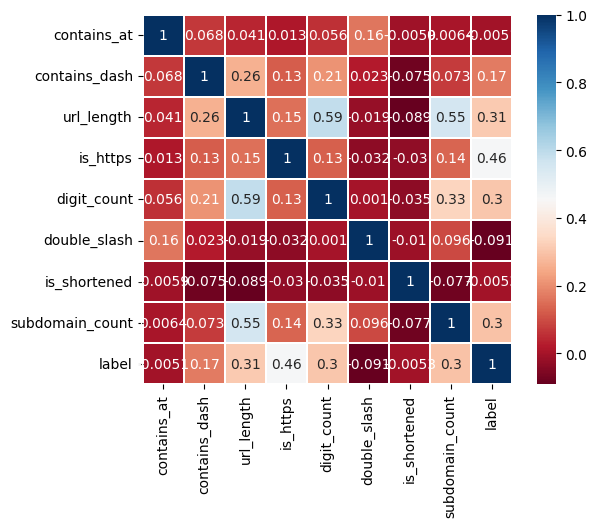

In [24]:
heatmap_data = df.select_dtypes(include=[np.number])
colormap = plt.cm.RdBu
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0,
            square=True, cmap=colormap, linecolor='white', annot=True,
            annot_kws={'size': 10})
plt.show()

# Logistic 회귀 모델

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 데이터 준비 (독립 변수와 종속 변수 분리)
X1 = df.drop(columns=['label'])
y1 = df['label']

val_input1 = valset.drop(columns=['label'])
val_target1 = valset['label']

# 학습 데이터와 테스트 데이터로 분할
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=42)

In [26]:
# 로지스틱 회귀 모델 생성 및 학습
logistic_model = LogisticRegression()
logistic_model.fit(X_train1, y_train1)

LogisticRegression()

In [27]:
# 모델 평가
y_pred1 = logistic_model.predict(X_test1)

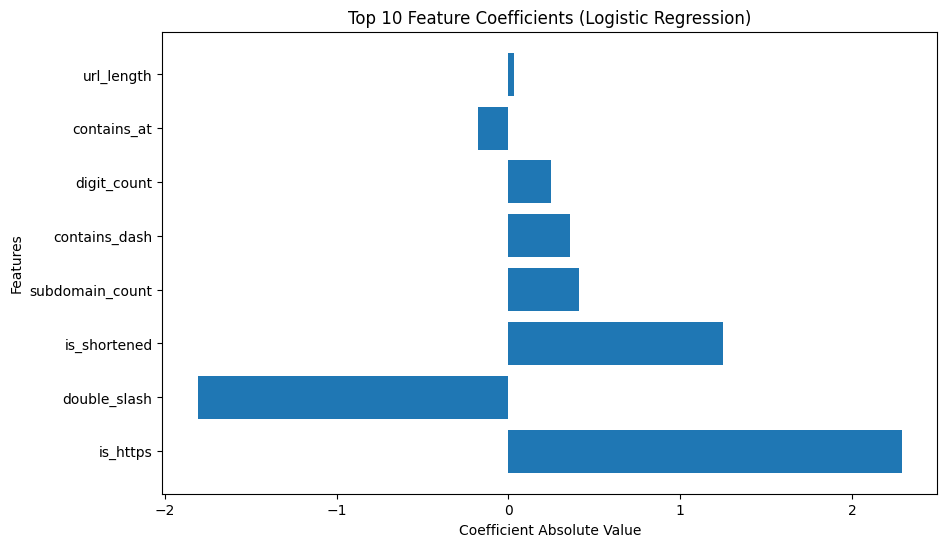

In [28]:
import matplotlib.pyplot as plt

# 학습된 로지스틱 회귀 모델의 계수
coefficients = logistic_model.coef_[0]

# 각 피처와 그 계수를 연결
feature_names = X_train1.columns
coefficients_dict = dict(zip(feature_names, coefficients))

# 계수의 절대값을 기준으로 내림차순 정렬
sorted_coefficients = sorted(coefficients_dict.items(), key=lambda x: abs(x[1]), reverse=True)

# 상위 N개의 피처만 선택 (예: 상위 10개)
top_n = 10
top_features = dict(sorted_coefficients[:top_n])

# 그래프로 시각화
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_features)), top_features.values(), align='center')
plt.yticks(range(len(top_features)), top_features.keys())
plt.xlabel('Coefficient Absolute Value')
plt.ylabel('Features')
plt.title('Top {} Feature Coefficients (Logistic Regression)'.format(top_n))
plt.show()


In [29]:
# 정확도 출력
accuracy = accuracy_score(y_test1, y_pred1)
print("Accuracy:", accuracy)

Accuracy: 0.7674000898069151


In [30]:
# 분류 보고서 출력
classification_rep1 = classification_report(y_test1, y_pred1)
print("Classification Report:\n", classification_rep1)


Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.71      0.75      9936
           1       0.74      0.83      0.78     10107

    accuracy                           0.77     20043
   macro avg       0.77      0.77      0.77     20043
weighted avg       0.77      0.77      0.77     20043



In [31]:
# 혼동 행렬 출력
conf_matrix1 = confusion_matrix(y_test1, y_pred1)
print("Confusion Matrix:\n", conf_matrix1)

Confusion Matrix:
 [[7026 2910]
 [1752 8355]]


In [32]:
# 검증데이터 평가
val_pred1 = logistic_model.predict(val_input1)

In [33]:
# 정확도 출력
accuracy = accuracy_score(val_target1, val_pred1)
print("Accuracy:", accuracy)

Accuracy: 0.7638


In [34]:
# 분류 보고서 출력
classification_val1 = classification_report(val_target1, val_pred1)
print("Classification Report:\n", classification_val1)


Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.70      0.75      5000
           1       0.74      0.82      0.78      5000

    accuracy                           0.76     10000
   macro avg       0.77      0.76      0.76     10000
weighted avg       0.77      0.76      0.76     10000



In [35]:
# 혼동 행렬 출력
conf_matrix11 = confusion_matrix(val_target1, val_pred1)
print("Confusion Matrix:\n", conf_matrix11)

Confusion Matrix:
 [[3523 1477]
 [ 885 4115]]


# LGBM 모델

In [93]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 데이터 준비 (독립 변수와 종속 변수 분리)
X2 = df.drop(columns=['label'])
y2 = df['label']
val_input2 = valset.drop(columns=['label'])
val_target2 = valset['label']

# 컬럼 이름 정제 (공백과 특수 문자를 언더스코어(_)로 변경)
val_input2.columns = val_input2.columns.str.replace('[^a-zA-Z0-9]', '_')
X2.columns = X2.columns.str.replace('[^a-zA-Z0-9]', '_')

# 학습 데이터와 테스트 데이터로 분할
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

# LightGBM 데이터셋 생성
train_data2 = lgb.Dataset(X_train2, label=y_train2)
test_data2 = lgb.Dataset(X_test2, label=y_test2, reference=train_data2)

# LightGBM 모델 설정 (나머지 코드는 이전과 동일)
params = {
    'objective': 'binary',  # 이진 분류 설정
    'metric': 'binary_error',  # 이진 분류 정확도 측정
    'boosting_type': 'rf',  # Gradient Boosting Decision Tree
    'num_leaves': 31,  # 과적합 방지를 위해 트리의 최대 잎 노드 수 줄임
    'learning_rate': 0.005,  # 과적합 방지를 위해 낮은 학습률 설정
    'feature_fraction': 0.9,  # 트리마다 무작위로 선택되는 피처 비율 줄임
    'bagging_fraction': 0.9,  # 각 반복마다 무작위로 선택되는 데이터 비율 줄임
    'bagging_freq': 5,  # 5번의 반복마다 배깅 수행
    # 'lambda_l1': 0.1,  # L1 정규화 적용
    # 'lambda_l2': 0.1,  # L2 정규화 적용
    'max_depth': 8  # 과적합 방지를 위해 트리의 최대 깊이 제한
}

<ipython-input-93-40cfb294312a>:13: FutureWarning: The default value of regex will change from True to False in a future version.
  val_input2.columns = val_input2.columns.str.replace('[^a-zA-Z0-9]', '_')
<ipython-input-93-40cfb294312a>:14: FutureWarning: The default value of regex will change from True to False in a future version.
  X2.columns = X2.columns.str.replace('[^a-zA-Z0-9]', '_')


In [94]:
# LightGBM 모델 학습
num_round = 10  # 트리 수 (조정 가능)
lgb_model = lgb.train(params, train_data2, num_round)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 40104, number of negative: 40064
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 131
[LightGBM] [Info] Number of data points in the train set: 80168, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500249 -> initscore=0.000998
[LightGBM] [Info] Start training from score 0.000998


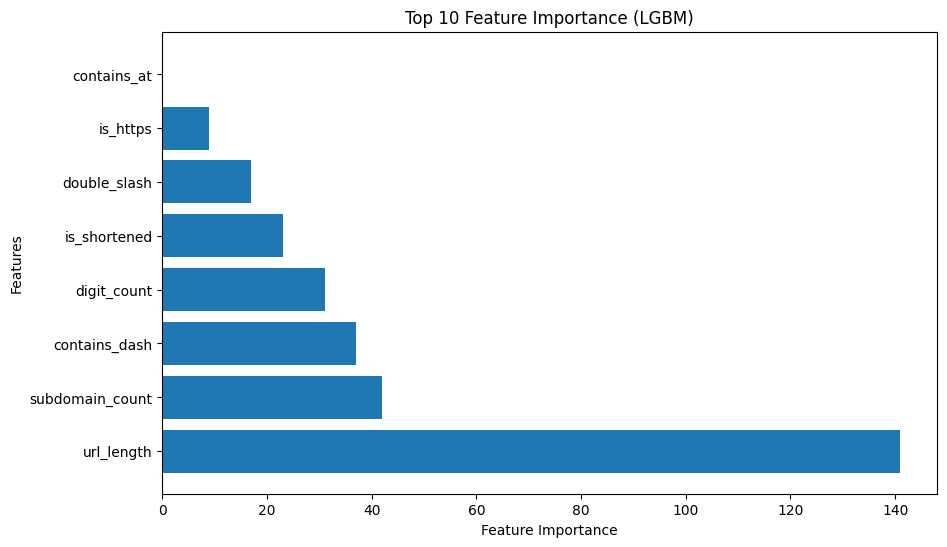

In [95]:
import matplotlib.pyplot as plt

# LightGBM 모델에서 피쳐 중요도 가져오기
feature_importance = lgb_model.feature_importance()
feature_names = X_train2.columns

# 중요도를 피쳐 이름과 연결
feature_importance_dict = dict(zip(feature_names, feature_importance))

# 중요도를 기준으로 내림차순 정렬
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# 상위 N개의 피쳐만 선택 (예: 상위 10개)
top_n = 10
top_features = dict(sorted_feature_importance[:top_n])

# 그래프로 시각화
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_features)), top_features.values(), align='center')
plt.yticks(range(len(top_features)), top_features.keys())
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top {} Feature Importance (LGBM)'.format(top_n))
plt.show()


In [96]:
# 모델 예측
y_pred2 = lgb_model.predict(X_test2, num_iteration=lgb_model.best_iteration)
y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred2]  # 이진 예측

In [97]:
# 정확도 출력
accuracy = accuracy_score(y_test2, y_pred_binary)
print("Accuracy:", accuracy)

Accuracy: 0.8309135358978197


In [98]:
# 분류 보고서 출력
classification_rep2 = classification_report(y_test2, y_pred_binary)
print("Classification Report:\n", classification_rep2)

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.85      0.83      9936
           1       0.84      0.81      0.83     10107

    accuracy                           0.83     20043
   macro avg       0.83      0.83      0.83     20043
weighted avg       0.83      0.83      0.83     20043



In [99]:
# 혼동 행렬 출력
conf_matrix2 = confusion_matrix(y_test2, y_pred_binary)
print("Confusion Matrix:\n", conf_matrix2)

Confusion Matrix:
 [[8424 1512]
 [1877 8230]]


In [100]:
# 검증 데이터 예측
val_pred2 = lgb_model.predict(val_input2, num_iteration=lgb_model.best_iteration)
val_pred_binary = [1 if pred > 0.5 else 0 for pred in val_pred2]  # 이진 예측

In [101]:
len(val_pred_binary)

10000

In [102]:
# 정확도 출력
accuracy = accuracy_score(val_target2, val_pred_binary)
print("Accuracy:", accuracy)

Accuracy: 0.8329


In [103]:
# 분류 보고서 출력
classification_val22 = classification_report(val_target2, val_pred_binary)
print("Classification Report:\n", classification_val22)

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.85      0.84      5000
           1       0.85      0.81      0.83      5000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



# RandomForest

In [104]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 데이터 준비 (독립 변수와 종속 변수 분리)
X3 = df.drop(columns=['label'])
y3 = df['label']

val_input3 = valset.drop(columns=['label'])
val_target3 = valset['label']


In [48]:
# 학습 데이터와 테스트 데이터로 분할
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.2, random_state=42)

In [49]:
# 랜덤 포레스트 모델 생성 및 학습
rf_model3 = RandomForestClassifier(random_state=42)
rf_model3.fit(X_train3, y_train3)

RandomForestClassifier(random_state=42)

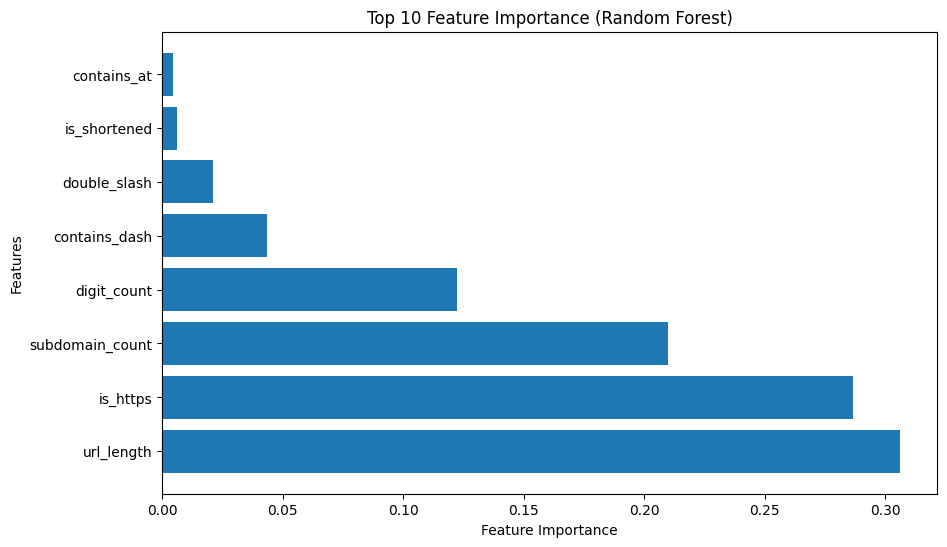

In [50]:
import matplotlib.pyplot as plt

# 학습된 Random Forest 모델에서 피처 중요도 가져오기
feature_importance = rf_model3.feature_importances_

# 각 피처와 그 중요도를 연결
feature_names = X_train3.columns
feature_importance_dict = dict(zip(feature_names, feature_importance))

# 중요도를 기준으로 내림차순 정렬
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# 상위 N개의 피처만 선택 (예: 상위 10개)
top_n = 10
top_features = dict(sorted_feature_importance[:top_n])

# 그래프로 시각화
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_features)), top_features.values(), align='center')
plt.yticks(range(len(top_features)), top_features.keys())
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top {} Feature Importance (Random Forest)'.format(top_n))
plt.show()


In [51]:
# 모델 예측
y_pred3 = rf_model3.predict(X_test3)

In [52]:
# 정확도 출력
accuracy = accuracy_score(y_test3, y_pred3)
print("Accuracy:", accuracy)

# 분류 보고서 출력
classification_rep = classification_report(y_test3, y_pred3)
print("Classification Report:\n", classification_rep)

# 혼동 행렬 출력
conf_matrix = confusion_matrix(y_test3, y_pred3)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.8522177318764655
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.88      0.85      9936
           1       0.87      0.83      0.85     10107

    accuracy                           0.85     20043
   macro avg       0.85      0.85      0.85     20043
weighted avg       0.85      0.85      0.85     20043

Confusion Matrix:
 [[8726 1210]
 [1752 8355]]


In [53]:
# 모델 예측
val_pred3 = rf_model3.predict(val_input3)

In [54]:
# 정확도 출력
accuracy = accuracy_score(val_target3, val_pred3)
print("Accuracy:", accuracy)

# 분류 보고서 출력
classification_val3 = classification_report(val_target3, val_pred3)
print("Classification Report:\n", classification_val3)

# 혼동 행렬 출력
conf_matrix33 = confusion_matrix(y_test3, y_pred3)
print("Confusion Matrix:\n", conf_matrix33)

Accuracy: 0.8555
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.88      0.86      5000
           1       0.87      0.83      0.85      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

Confusion Matrix:
 [[8726 1210]
 [1752 8355]]


# SVM

In [55]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 데이터 준비 (독립 변수와 종속 변수 분리)
X4 = df.drop(columns=['label'])
y4 = df['label']

val_input4 = valset.drop(columns=['label'])
val_target4 = valset['label']

In [56]:
# 학습 데이터와 테스트 데이터로 분할
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, test_size=0.2, random_state=42)

In [57]:
# SVM 모델 생성 및 학습
svm_model = SVC(random_state=42)
svm_model.fit(X_train4, y_train4)

SVC(random_state=42)

In [58]:
# 모델 예측
y_pred4 = svm_model.predict(X_test4)

# 정확도 출력
accuracy = accuracy_score(y_test4, y_pred4)
print("Accuracy:", accuracy)

# 분류 보고서 출력
classification_rep = classification_report(y_test4, y_pred4)
print("Classification Report:\n", classification_rep)

# 혼동 행렬 출력
conf_matrix = confusion_matrix(y_test4, y_pred4)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.7812203761911889
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.75      0.77      9936
           1       0.77      0.82      0.79     10107

    accuracy                           0.78     20043
   macro avg       0.78      0.78      0.78     20043
weighted avg       0.78      0.78      0.78     20043

Confusion Matrix:
 [[7404 2532]
 [1853 8254]]


In [59]:
# 검증 데이터 예측
val_pred4 = svm_model.predict(val_input4)

# 정확도 출력
accuracy = accuracy_score(val_target4, val_pred4)
print("Accuracy:", accuracy)

# 분류 보고서 출력
classification_val4 = classification_report(val_target4, val_pred4)
print("Classification Report:\n", classification_val4)

# 혼동 행렬 출력
conf_matrix44 = confusion_matrix(val_target4, val_pred4)
print("Confusion Matrix:\n", conf_matrix44)

Accuracy: 0.774
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.74      0.77      5000
           1       0.76      0.81      0.78      5000

    accuracy                           0.77     10000
   macro avg       0.78      0.77      0.77     10000
weighted avg       0.78      0.77      0.77     10000

Confusion Matrix:
 [[3705 1295]
 [ 965 4035]]


In [60]:
# import matplotlib.pyplot as plt
# import numpy as np

# # 선형 SVM 모델 생성 및 학습
# svm_model = SVC(kernel='linear', random_state=42)
# svm_model.fit(X_train4, y_train4)

# # 모델 계수를 가져옵니다
# coefs = np.abs(svm_model.coef_[0])

# # 피처 이름과 계수를 연결
# feature_names = X_train4.columns
# feature_importance_dict = dict(zip(feature_names, coefs))

# # 중요도를 기준으로 내림차순 정렬
# sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# # 상위 N개의 피처만 선택 (예: 상위 10개)
# top_n = 10
# top_features = dict(sorted_feature_importance[:top_n])

# # 그래프로 시각화
# plt.figure(figsize=(10, 6))
# plt.barh(list(top_features.keys()), list(top_features.values()))
# plt.xlabel('Feature Importance')
# plt.ylabel('Features')
# plt.title(f'Top {top_n} Feature Importance in Linear SVM Model')
# plt.gca().invert_yaxis() # 피처를 중요도 높은 순으로 표시
# plt.show()

AttributeError: coef_ is only available when using a linear kernel

# LSTM

In [63]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

# 데이터 준비 (독립 변수와 종속 변수 분리)
X5 = df.drop(columns=['label'])
y5 = df['label']

val_input5 = valset.drop(columns=['label'])
val_target5 = valset['label']


# 학습 데이터와 테스트 데이터로 분할
X_train5, X_test5, y_train5, y_test5 = train_test_split(X5, y5, test_size=0.2, random_state=42)

# 데이터 전처리
scaler = StandardScaler()
X_train5 = scaler.fit_transform(X_train5)
X_test5 = scaler.transform(X_test5)


# LSTM 모델 생성
model = Sequential()
model.add(LSTM(128, input_shape=(X_train5.shape[1], 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# 고정 학습률 설정
optimizer = Adam(lr=0.001)  # 초기 학습률을 0.001로 설정

# 모델 컴파일
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
# # 모델 컴파일
# model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

# 학습률을 에포크에 따라 감소시키는 함수 정의
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)



# 데이터 형식 조정
X_train5 = X_train5.reshape(X_train5.shape[0], X_train5.shape[1], 1)
X_test5 = X_test5.reshape(X_test5.shape[0], X_test5.shape[1], 1)

# Early Stopping 적용
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 모델 체크포인트
model_checkpoint = ModelCheckpoint(
    'best_model.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)

# 학습률을 에포크에 따라 감소시키는 함수 정의
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# 콜백 생성
lr_scheduler = LearningRateScheduler(scheduler)

# 모델 학습
history = model.fit(X_train5, y_train5, epochs=10, batch_size=64)

Epoch 1/10
1253/1253 [==============================] - 83s 63ms/step - loss: 0.5788 - accuracy: 0.6766
Epoch 2/10
1253/1253 [==============================] - 101s 81ms/step - loss: 0.5581 - accuracy: 0.6904
Epoch 3/10
1253/1253 [==============================] - 63s 51ms/step - loss: 0.5493 - accuracy: 0.6956
Epoch 4/10
1253/1253 [==============================] - 73s 58ms/step - loss: 0.5440 - accuracy: 0.6976
Epoch 5/10
1253/1253 [==============================] - 63s 50ms/step - loss: 0.5402 - accuracy: 0.6996
Epoch 6/10
1253/1253 [==============================] - 64s 51ms/step - loss: 0.5371 - accuracy: 0.7015
Epoch 7/10
1253/1253 [==============================] - 63s 50ms/step - loss: 0.5346 - accuracy: 0.7029
Epoch 8/10
1253/1253 [==============================] - 64s 51ms/step - loss: 0.5321 - accuracy: 0.7052
Epoch 9/10
1253/1253 [==============================] - 63s 50ms/step - loss: 0.5294 - accuracy: 0.7072
Epoch 10/10
1253/1253 [==============================] - 65s 52

In [64]:
# 모델 평가
y_pred5 = model.predict(X_test5)

# y_pred5의 첫 번째 차원을 유지하고 나머지 차원을 제거
y_pred5_squeezed = np.squeeze(y_pred5)

print(y_pred5_squeezed.shape)

627/627 [==============================] - 8s 11ms/step
(20043, 8)


In [65]:
# 만약 여전히 y_pred5_squeezed가 다차원 배열이라면, 추가적인 처리가 필요
if y_pred5_squeezed.ndim > 1:
    # 예를 들어, y_pred5_squeezed가 2차원 배열이라면, 적절한 열 선택
    y_pred5_squeezed = y_pred5_squeezed[:, 0]  # 예를 들어 첫 번째 열을 선택

# 이진 예측 생성
y_pred_binary5 = [1 if pred > 0.5 else 0 for pred in y_pred5_squeezed]

# 정확도 계산
accuracy = accuracy_score(y_test5, y_pred_binary5)
print("Accuracy:", accuracy)

Accuracy: 0.49428728234296265


In [66]:

# 혼동 행렬
conf_matrix = confusion_matrix(y_test5, y_pred_binary5)
print("Confusion Matrix:")
print(conf_matrix)

# 분류 보고서
class_report = classification_report(y_test5, y_pred_binary5)
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[9772  164]
 [9972  135]]

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.98      0.66      9936
           1       0.45      0.01      0.03     10107

    accuracy                           0.49     20043
   macro avg       0.47      0.50      0.34     20043
weighted avg       0.47      0.49      0.34     20043



In [67]:
# 모델 평가
val_pred5 = model.predict(val_input5)

# y_pred5의 첫 번째 차원을 유지하고 나머지 차원을 제거
val_pred5_squeezed = np.squeeze(val_pred5)

# 만약 여전히 y_pred5_squeezed가 다차원 배열이라면, 추가적인 처리가 필요
if val_pred5_squeezed.ndim > 1:
    # 예를 들어, y_pred5_squeezed가 2차원 배열이라면, 적절한 열 선택
    val_pred5_squeezed = val_pred5_squeezed[:, 2]  # 예를 들어 첫 번째 열을 선택

# 이진 예측 생성
val_pred_binary5 = [1 if pred > 0.5 else 0 for pred in val_pred5_squeezed]

# 정확도 계산
accuracy = accuracy_score(val_target5, val_pred_binary5)
print("Accuracy:", accuracy)

# 분류 보고서 출력
classification_val5 = classification_report(val_target5, val_pred_binary5)
print("Classification Report:\n", classification_val5)

# 혼동 행렬 출력
conf_matrix55 = confusion_matrix(val_target5, val_pred_binary5)
print("Confusion Matrix:\n", conf_matrix55)

313/313 [==============================] - 6s 16ms/step
Accuracy: 0.5
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      5000
           1       0.50      1.00      0.67      5000

    accuracy                           0.50     10000
   macro avg       0.25      0.50      0.33     10000
weighted avg       0.25      0.50      0.33     10000

Confusion Matrix:
 [[   0 5000]
 [   0 5000]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# XGBOOST

In [69]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# 데이터 준비 (독립 변수와 종속 변수 분리)
X6 = df.drop(columns=['label'])
y6 = df['label']
val_input6 = valset.drop(columns=['label'])
val_target6 = valset['label']

# 컬럼 이름 정제 (공백과 특수 문자를 언더스코어(_)로 변경)
val_input6.columns = val_input6.columns.str.replace('[^a-zA-Z0-9]', '_', regex=True)
X6.columns = X6.columns.str.replace('[^a-zA-Z0-9]', '_', regex=True)

# 학습 데이터와 테스트 데이터로 분할
X_train6, X_test6, y_train6, y_test6 = train_test_split(X6, y6, test_size=0.2, random_state=42)


# XGBoost 데이터셋 생성
dtrain6 = xgb.DMatrix(X_train6, label=y_train6)
dtest6 = xgb.DMatrix(X_test6, label=y_test6)

# XGBoost 모델 설정
params = {
    'objective': 'binary:logistic',  # 이진 분류 설정
    'eval_metric': 'error',  # 이진 분류 오류율
    'booster': 'gbtree',  # 트리 기반 모델
    'max_depth': 6,  # 트리의 최대 깊이
    'eta': 0.3,  # 학습률
    'subsample': 0.8,  # 훈련 데이터의 하위 샘플 비율
}

In [70]:
# XGBoost 모델 학습
num_round = 10  # 부스팅 라운드 수 (조정 가능)
bst = xgb.train(params, dtrain6, num_round)

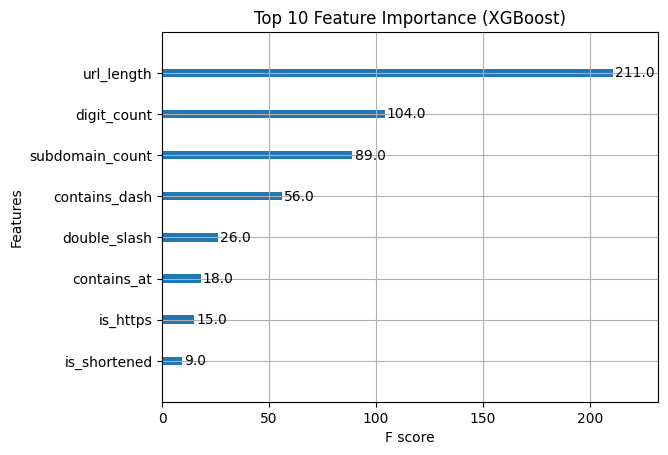

In [83]:
# 피쳐 중요도 가져오기 및 시각화
xgb.plot_importance(bst, max_num_features=10)
plt.title('Top 10 Feature Importance (XGBoost)')
plt.show()


In [84]:
# 모델 예측
y_pred6 = bst.predict(dtest6)
y_pred_binary6 = [1 if pred > 0.5 else 0 for pred in y_pred6]  # 이진 예측


In [85]:
# 정확도 출력
accuracy = accuracy_score(y_test6, y_pred_binary6)
print("Accuracy:", accuracy)


Accuracy: 0.837798732724642


In [86]:
# 분류 보고서 출력
classification_rep6 = classification_report(y_test6, y_pred_binary6)
print("Classification Report:\n", classification_rep6)

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.85      0.84      9936
           1       0.85      0.83      0.84     10107

    accuracy                           0.84     20043
   macro avg       0.84      0.84      0.84     20043
weighted avg       0.84      0.84      0.84     20043



In [89]:
# 혼동 행렬 출력
conf_matrix2 = confusion_matrix(y_test2, y_pred_binary6)
print("Confusion Matrix:\n", conf_matrix2)

Confusion Matrix:
 [[8433 1503]
 [1748 8359]]


In [91]:
# 검증 데이터셋에 대한 예측
dval6 = xgb.DMatrix(val_input6)
val_pred6 = bst.predict(dval6)
val_pred_binary6 = [1 if pred > 0.5 else 0 for pred in val_pred6]  # 이진 예측

# 정확도 출력
accuracy = accuracy_score(val_target6, val_pred_binary6)
print("Validation Accuracy:", accuracy)

# 분류 보고서 출력
classification_val6 = classification_report(val_target6, val_pred_binary6)  # val_pred6 대신 val_pred_binary 사용
print("Classification Report:\n", classification_val6)

# 혼동 행렬 출력
conf_matrix66 = confusion_matrix(val_target6, val_pred_binary6)  # val_pred6 대신 val_pred_binary 사용
print("Confusion Matrix:\n", conf_matrix66)

Validation Accuracy: 0.8399
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.85      0.84      5000
           1       0.85      0.83      0.84      5000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000

Confusion Matrix:
 [[4258  742]
 [ 859 4141]]


# 모델 비교평가

In [105]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 예측 결과와 실제 레이블
# 여기서 y_test는 실제 테스트 데이터 레이블이며, 각 모델의 예측 결과는 각각의 변수에 저장되어 있다고 가정
y_test = y_test1
y_pred_lgbm = y_pred_binary
y_pred_logistic = y_pred1
y_pred_rf = y_pred3
y_pred_lstm = y_pred_binary5
y_pred_svm = y_pred4
y_pred_xgb = y_pred_binary6

# 각 모델의 성능 지표 계산
models = ['LightGBM', 'Logistic Regression', 'Random Forest', 'LSTM', 'SVM', 'XGB']
y_preds = [y_pred_lgbm, y_pred_logistic, y_pred_rf, y_pred_lstm, y_pred_svm, y_pred_xgb]

for model, y_pred in zip(models, y_preds):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"{model} - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")


LightGBM - Accuracy: 0.83, Precision: 0.84, Recall: 0.81, F1 Score: 0.83
Logistic Regression - Accuracy: 0.77, Precision: 0.74, Recall: 0.83, F1 Score: 0.78
Random Forest - Accuracy: 0.85, Precision: 0.87, Recall: 0.83, F1 Score: 0.85
LSTM - Accuracy: 0.49, Precision: 0.45, Recall: 0.01, F1 Score: 0.03
SVM - Accuracy: 0.78, Precision: 0.77, Recall: 0.82, F1 Score: 0.79
XGB - Accuracy: 0.84, Precision: 0.85, Recall: 0.83, F1 Score: 0.84


In [107]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 예측 결과와 실제 레이블
# 여기서 y_test는 실제 테스트 데이터 레이블이며, 각 모델의 예측 결과는 각각의 변수에 저장되어 있다고 가정
y_test = val_target1
y_pred_lgbm = val_pred_binary
y_pred_logistic = val_pred1
y_pred_rf = val_pred3
y_pred_lstm = val_pred_binary5
y_pred_svm = val_pred4
y_pred_xgb = val_pred_binary6

# 각 모델의 성능 지표 계산
models = ['LightGBM', 'Logistic Regression', 'Random Forest', 'LSTM', 'SVM', 'XGB']
y_preds = [y_pred_lgbm, y_pred_logistic, y_pred_rf,y_pred_lstm, y_pred_svm, y_pred_xgb]

for model, y_pred in zip(models, y_preds):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"{model} - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")


LightGBM - Accuracy: 0.83, Precision: 0.85, Recall: 0.81, F1 Score: 0.83
Logistic Regression - Accuracy: 0.76, Precision: 0.74, Recall: 0.82, F1 Score: 0.78
Random Forest - Accuracy: 0.86, Precision: 0.87, Recall: 0.83, F1 Score: 0.85
LSTM - Accuracy: 0.50, Precision: 0.50, Recall: 1.00, F1 Score: 0.67
SVM - Accuracy: 0.77, Precision: 0.76, Recall: 0.81, F1 Score: 0.78
XGB - Accuracy: 0.84, Precision: 0.85, Recall: 0.83, F1 Score: 0.84
